In [1]:
import scipy.linalg
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import numba
plt.style.use('ggplot')

Problem 1: CP_ALS

In [21]:
# I use my unfold instead of the reshape function. 
@numba.jit
def unfold(tensor,mode):
    return np.reshape(np.moveaxis(tensor, mode, 0), (tensor.shape[mode], -1), order='F')
# geterro function returns the difference between my result (after reshape into the tensor) and the original tensor. 
def geterror(cp,lambdal,tensor):
    Sum = np.zeros(tensor.shape)
    R = len(lambdal)
    for r in range(R):
        prod = cp[0][:,r]*lambdal[r]
        for i in cp[1:]:
            prod = np.multiply.outer(prod,i[:,r])
        Sum = np.add(Sum,prod)
    difference = np.add(Sum,(-1)*tensor)
    return scipy.linalg.norm(difference)
# as the other products are just in numpy, I only implement the khatri_rao product for matrix (A,B)

@numba.jit
def khatri_rao(A,B):
    product = A[...,:,np.newaxis,:]*B[...,np.newaxis,:,:]
    shape2 = product.shape[2:]
    return product.reshape((-1,)+shape2)

In [22]:
tensor = scipy.io.loadmat('cp_fc_layer.mat')['A']

In [25]:

def CP_ALS(tensor,R):
    print(R)
    shape = tensor.shape
    N = len(shape)
    A_lst = [np.random.rand(shape[n],R) for n in range(N)]
    loop = 0
    lamb = np.zeros((R))
    while True:
        pre_error = geterror(A_lst,lamb,tensor) 
        for n in range(0,N):
            curr_A = A_lst[n]
            V = None
            Ak = None
            X_n = unfold(tensor,n)
            for i in range(0,N):
                if i != n:
                    if V is None:
                        V=np.dot(A_lst[i].T,A_lst[i])
                    else:
                        V = V * np.dot(A_lst[i].T,A_lst[i])
            for i in range(N-1,-1,-1):
                if i != n:
                    if Ak is None:
                        Ak = A_lst[i]
                    else:
                        Ak = khatri_rao(Ak,A_lst[i])
            A_n = np.dot(np.dot(X_n,Ak),scipy.linalg.pinv(V))
            A_lst[n] = np.apply_along_axis(lambda c: c / scipy.linalg.norm(c),0,A_n)
            lamb =np.apply_along_axis(lambda c:  scipy.linalg.norm(c),0,A_n)
        current_error = geterror(A_lst,lamb,tensor)
        loop += 1
        # my stopping depend on the convergence of error as defined before. 
        if abs(pre_error - current_error)<1e-7 or loop>30:
            break
    return A_lst, lamb

In [26]:
myresult = [CP_ALS(tensor,i) for i in range(20,51)]

20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50


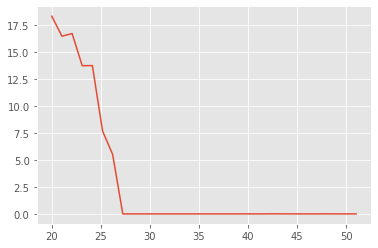

In [27]:
myerror = [geterror(i[0],i[1],tensor) for i in myresult]
xaxis = np.linspace(20,51,31)
plt.plot(xaxis,myerror)

In [29]:
myerror

[18.28228144454963,
 16.438789256955044,
 16.68405752506507,
 13.707967889719962,
 13.719971864744785,
 7.68211873682142,
 5.493213409744739,
 3.0848913409565325e-06,
 4.4309952924642264e-06,
 3.109752519453288e-06,
 0.0006471244825843052,
 0.0003544006285310339,
 2.4649530191003955e-05,
 3.125151578909686e-06,
 9.214565895086138e-06,
 4.01235709505213e-06,
 3.1221764633998464e-06,
 3.291128883676009e-06,
 7.242373166331817e-05,
 0.0025305744688787226,
 6.556681237317201e-06,
 0.0004134286886499594,
 0.009372771051241386,
 0.0020959044271181325,
 0.00010290485964616061,
 4.960545171722478e-06,
 4.062751796059088e-05,
 0.0032110797264419903,
 0.000594041250925869,
 1.584556261913299e-05,
 0.0007728754580523183]

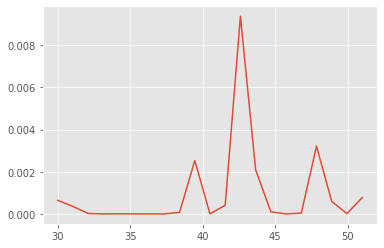

In [28]:
myerror_zoom_in = [geterror(i[0],i[1],tensor) for i in myresult[10:]]
xaxis_2 = np.linspace(30,51,21)
plt.plot(xaxis_2,myerror_zoom_in)